In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Input,concatenate
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape
import copy

Using TensorFlow backend.


In [2]:
%matplotlib inline

batch_size = 512
original_dim = 784
epochs = 12

In [5]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_train=(len(x_train))
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))

dm_train= copy.deepcopy(x_train)
dm_test = copy.deepcopy(x_test)
dm_train[:,10:19,:,:]=np.zeros([len(x_train),9,28,1])
dm_test[:,10:19,:,:]=np.zeros([len(x_test),9,28,1])

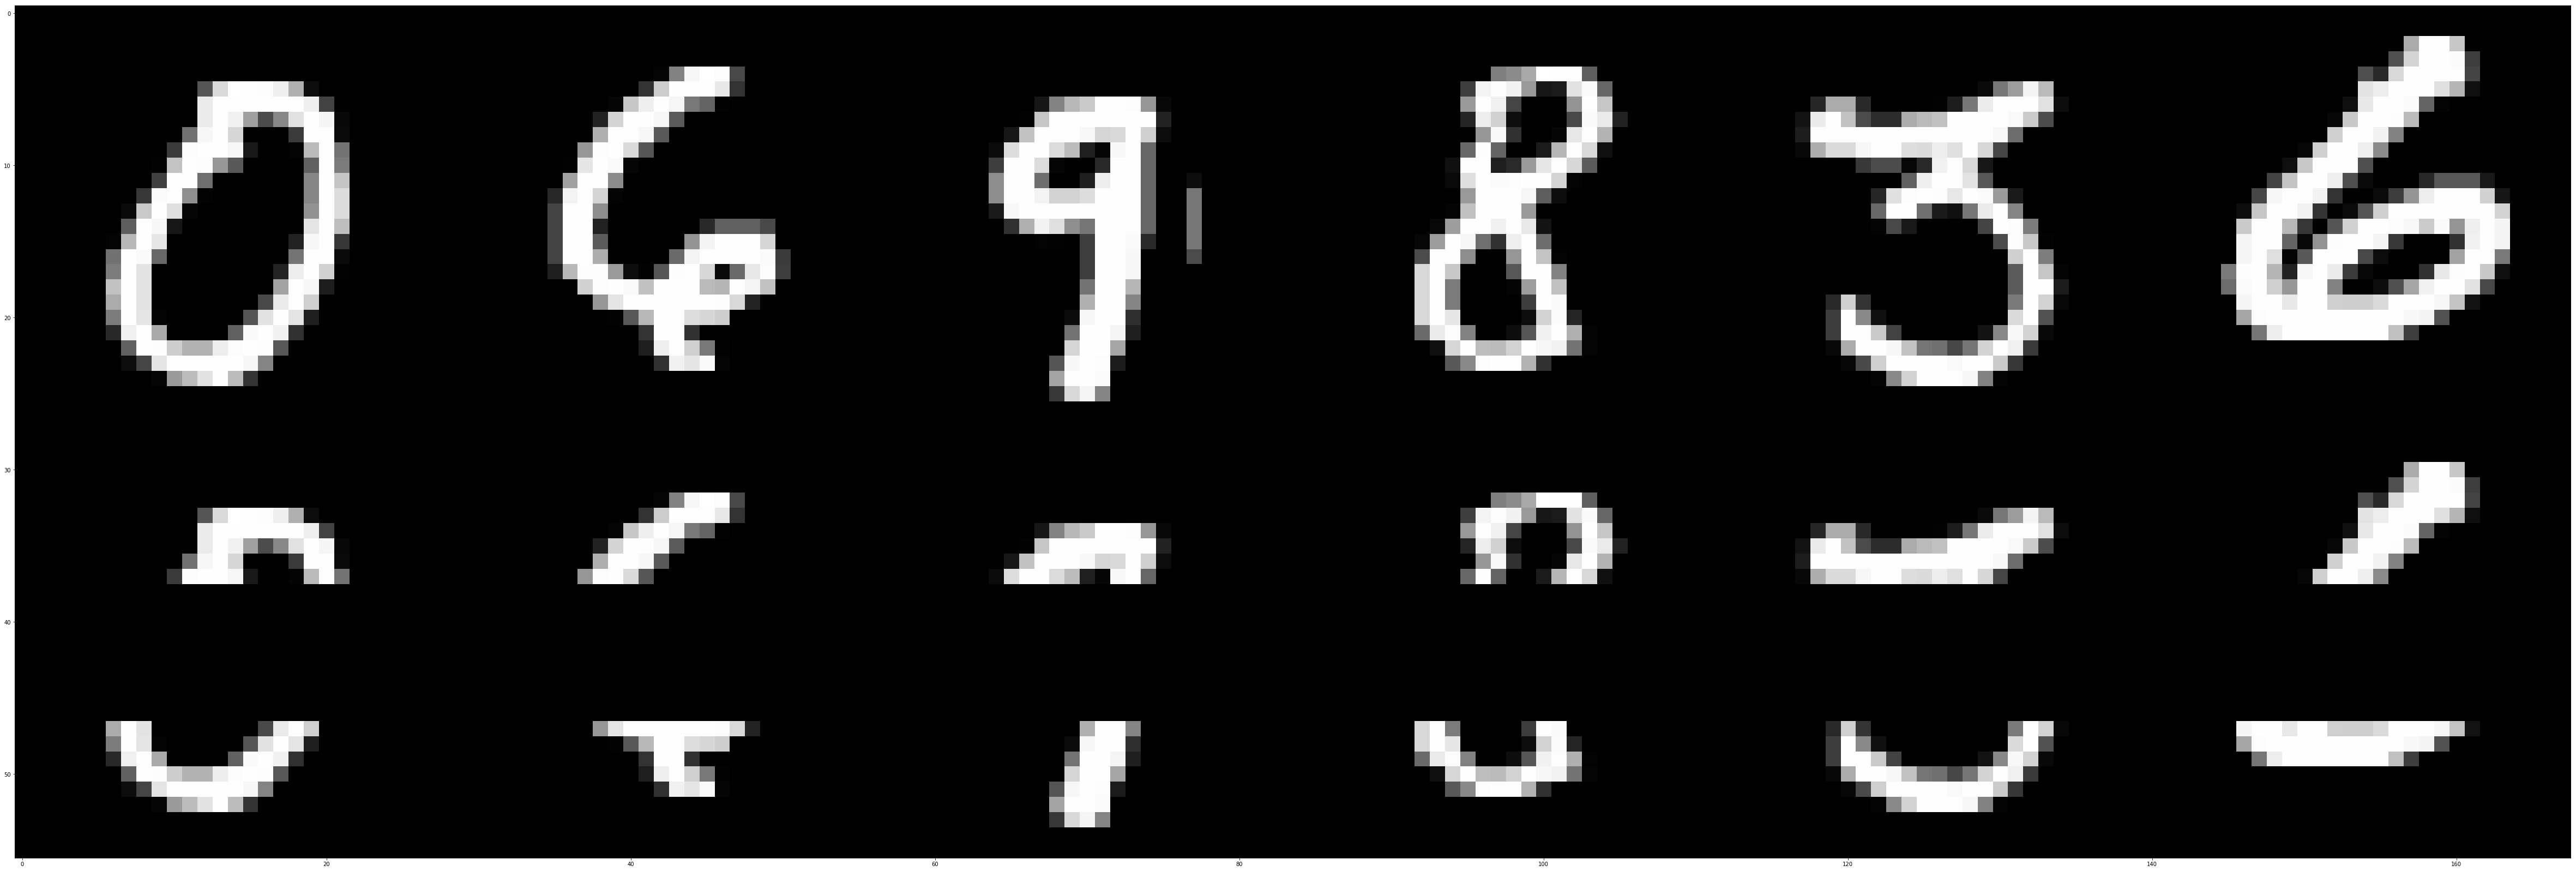

In [6]:
n_images = 6
figure = np.zeros((28*2 , 28 * n_images))
# Display
showidx=np.random.randint(0,num_train,n_images)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(dm_train[idx], [28, 28])
plt.figure(figsize=(28*3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [7]:
#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(16,(3, 3),padding='same',activation='relu')(x_noise)
conv_2 = Conv2D(32,(3, 3),padding='same',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(64,(3, 3),padding='same',activation='relu')(pool_1)#14*14*64
pool_2 = MaxPooling2D((2, 2))(conv_3)
conv_4 = Conv2D(128,(3, 3),padding='valid',activation='relu')(pool_2)#5*5*128
conv_5 = Conv2D(128,(3, 3),padding='valid',activation='relu')(conv_4)#3*3*128
conv_6 = Conv2D(256,(3, 3),padding='valid',activation='relu')(conv_5)#1*1*256
conv_7 = Conv2DTranspose(128,(3, 3), padding='valid',activation='relu')(conv_6)#3*3*128
conv_8 = Conv2DTranspose(128,(3, 3), padding='valid',activation='relu')(conv_7)#5*5*128

connec_1= concatenate([conv_4,conv_8],axis=-1)
conv_9 = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(connec_1)#7*7*64
conv_10 = Conv2DTranspose(64,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_9)#14*14*64

connec_2= concatenate([conv_3,conv_10],axis=-1)#14*14*64*2
conv_11 = Conv2DTranspose(32,(3, 3),padding='same', activation='relu')(connec_2)#14*14*32
conv_12 = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_11)#28*28*32

connec_3= concatenate([conv_2,conv_12],axis=-1)#28*28*32*2
conv_11 = Conv2DTranspose(16,(3, 3),padding='same', activation='relu')(connec_3)#28*28*16
x_out = Conv2DTranspose(1,(3, 3),padding='same', activation='relu')(conv_11)#28*28*16


In [8]:
U_Net = Model(x_noise, x_out)
U_Net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   4640        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(U_Net, to_file='model.png',show_shapes=True)

In [10]:
# Compute VAE loss
def AE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    ae_loss = K.mean(xent_loss)
    return ae_loss
U_Net.compile(optimizer='adam', loss=AE_loss)

In [11]:
U_Net.fit(dm_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(dm_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 29s 487us/step - loss: 181.2547 - val_loss: 120.9795
Epoch 2/12
60000/60000 [==============================] - 21s 350us/step - loss: 112.3841 - val_loss: 125.5133
Epoch 3/12
60000/60000 [==============================] - 21s 349us/step - loss: 108.9113 - val_loss: 99.4513
Epoch 4/12
60000/60000 [==============================] - 21s 350us/step - loss: 100.1429 - val_loss: 110.6896
Epoch 5/12
60000/60000 [==============================] - 21s 351us/step - loss: 98.4395 - val_loss: 90.6334
Epoch 6/12
60000/60000 [==============================] - 21s 351us/step - loss: 91.1689 - val_loss: 89.8068
Epoch 7/12
60000/60000 [==============================] - 21s 350us/step - loss: 89.8053 - val_loss: 88.0868
Epoch 8/12
60000/60000 [==============================] - 21s 350us/step - loss: 91.5694 - val_loss: 87.4944
Epoch 9/12
60000/60000 [==============================] - 21s 348us/ste

In [12]:
digit_size = 28
figure = np.zeros((digit_size * 3, digit_size * n_images))

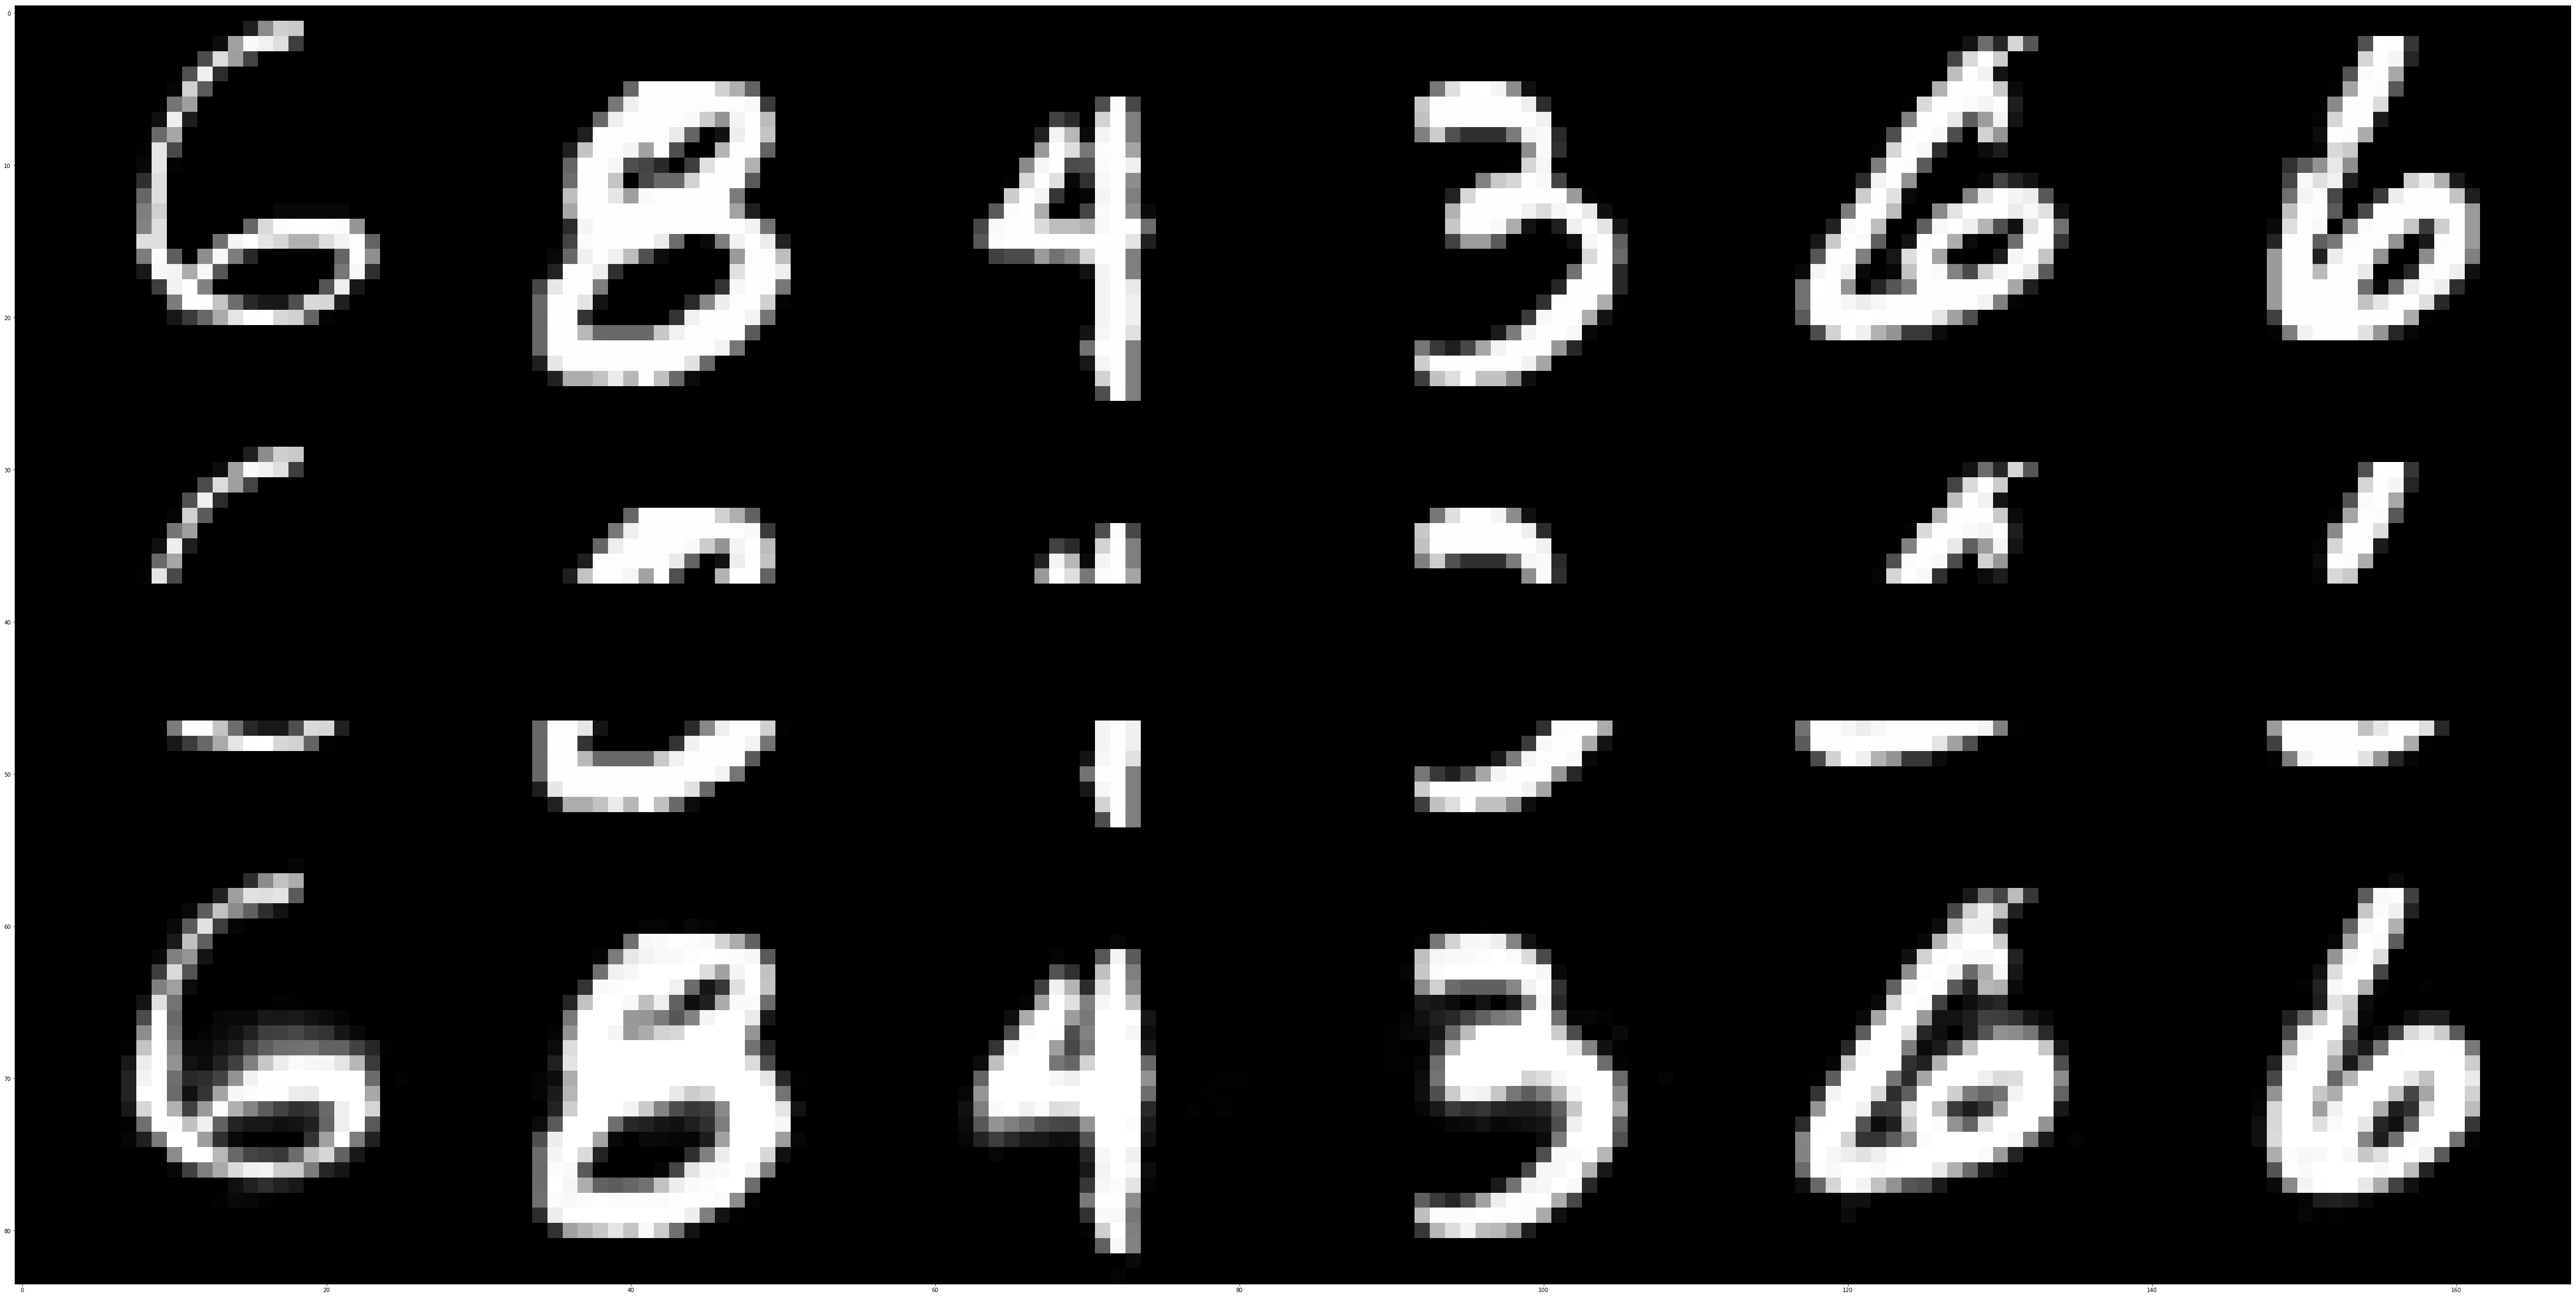

In [14]:
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=U_Net.predict(x_test[showidx])
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(dm_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] =  np.clip(np.reshape(x_out[i], [28, 28]), 0., 1.)
plt.figure(figsize=(28 * 3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('result_keras_U-Net.png')
plt.show()